# Epicenter computation with interrogators data
### Existing methods
In seismic waves propagation, one usually uses triangulation between stations, and the distance is estimated by computing the distance between the $P-$ and $S-$waves. In the particular framework of Acoustic Wave though, only one acoustic wave is propagating through the field. Therefore this method does not work. We aim at solving the epicenter inverse problem for the acoustic wave.

In [1]:
from PyAWD.AcousticWaveDataset import *
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
from IPython.display import display, Latex
sns.set_theme()

In [2]:
studied_axis = 1

In [3]:
train = torch.load("../../../local/datasets/AWD/train.pt")
X = [np.array([train.interrogate(i, inter) for inter in train.interrogators]).flatten() for i in range(train.size)]
Y = [train[i][0][studied_axis]/(train.nx/2) for i in range(train.size)]

In [4]:
test = torch.load("../../../local/datasets/AWD/test.pt")
X_test = np.array([np.array([test.interrogate(i, inter) for inter in test.interrogators]).flatten() for i in range(test.size)])
Y_test = np.array([test[i][0][studied_axis]/(test.nx/2) for i in range(test.size)])

## Data presentation

We work with pairs of data under the form:
- Epicenter $(x, y)$
- Wave mesured every $2$ seconds for $10$ seconds.

This follows the hypothese:
- We have an access on the wave amplitude at the given time points for all the spatial points.
  
As an example, sample $0$ starts at this epicenter:

In [5]:
print("Epicenter:", train[0][0])

Epicenter: [-23 -50]


and yields this propagation measurement:

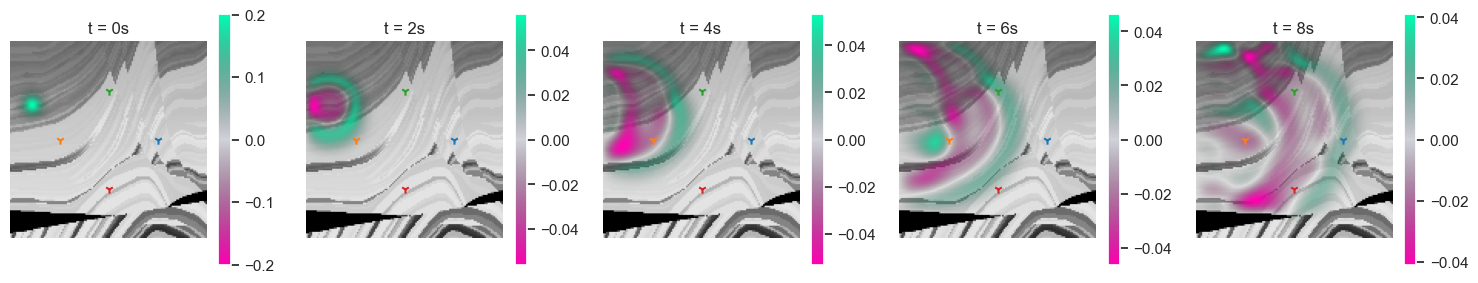

In [6]:
train.plot_item(0)

In [7]:
maes = {}
times = {}
Y_hat = {}

## Linear regression

We need to adapt the shape of the testing dataset:

In [8]:
t = time()
linear = LinearRegression().fit(X, Y)
Y_hat["Linear"] = linear.predict(X_test)
linear_mae = np.mean(np.abs(Y_test-Y_hat["Linear"]))
print("MAE:", linear_mae)
linear_t = time()-t
print("Computation time:", linear_t)
maes["Linear Regression"] = linear_mae
times["Linear Regression"] = linear_t

MAE: 3.4567022239789367
Computation time: 0.21733999252319336


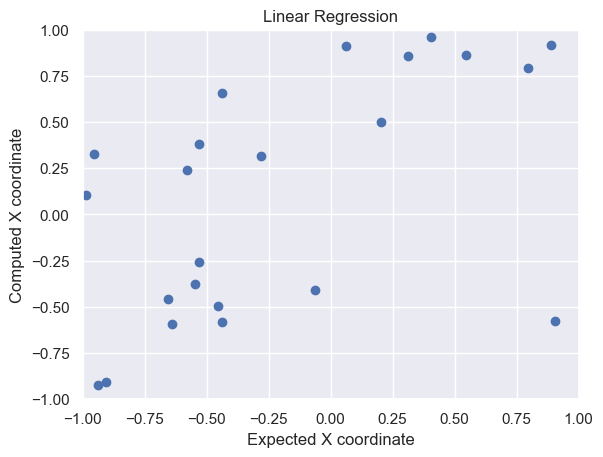

In [9]:
plt.scatter(Y_test, Y_hat["Linear"])
plt.xlabel("Expected X coordinate")
plt.ylabel("Computed X coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Linear Regression")
plt.savefig("../Results/LinearRegression"+str(studied_axis)+".jpg", dpi=250)

## Principal Components Analysis

In [10]:
t = time()
pca = PCA(n_components=64)
pca_model = pca.fit(X)
pca_t = time()-t
print("Computation time:", pca_t)

Computation time: 4.873078107833862


In [11]:
print("Input shape", pca_model.transform(X)[0].shape)

Input shape (64,)


### Linear regression on PCA

In [12]:
t = time()
linear_pca = LinearRegression().fit(pca_model.transform(X), Y)
Y_hat["Linear on PCA"] = linear_pca.predict(pca_model.transform(X_test))
linear_pca_mae = np.mean(np.abs(Y_test-Y_hat["Linear on PCA"]))
print("Normalized MAE:", linear_pca_mae)
linear_pca_t = time()-t + pca_t
print("Computation time:", linear_pca_t)
maes["Linear Regression on PCA"] = linear_pca_mae
times["Linear Regression on PCA"] = linear_pca_t

Normalized MAE: 0.2639774522700241
Computation time: 5.429721355438232


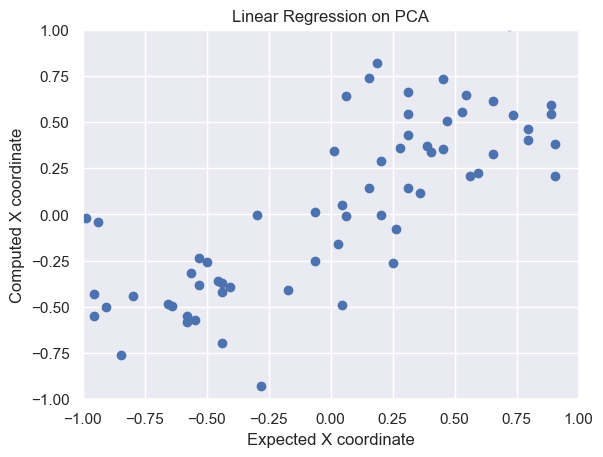

In [13]:
plt.scatter(Y_test, Y_hat["Linear on PCA"])
plt.xlabel("Expected X coordinate")
plt.ylabel("Computed X coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Linear Regression on PCA")
plt.savefig("../Results/LinearRegressionOnPCA"+str(studied_axis)+".jpg", dpi=250)

### Polynomial regression on PCA

In [14]:
t = time()
polynomial = PolynomialFeatures(degree=3)
feat_poly = polynomial.fit_transform(pca_model.transform(X))
poly_pca = LinearRegression().fit(feat_poly, Y)
feat_poly_test = polynomial.fit_transform(pca_model.transform(X_test))
Y_hat["Polynomial on PCA"] = poly_pca.predict(feat_poly_test)
poly_pca_mae = np.mean(np.abs(Y_test-Y_hat["Polynomial on PCA"]))
print("Normalized MAE:", poly_pca_mae)
poly_pca_t = time()-t + pca_t
print("Computation time:", poly_pca_t)
maes["Polynomial Regression on PCA"] = poly_pca_mae
times["Polynomial Regression on PCA"] = poly_pca_t

Normalized MAE: 4.394395783901774
Computation time: 8.54962706565857


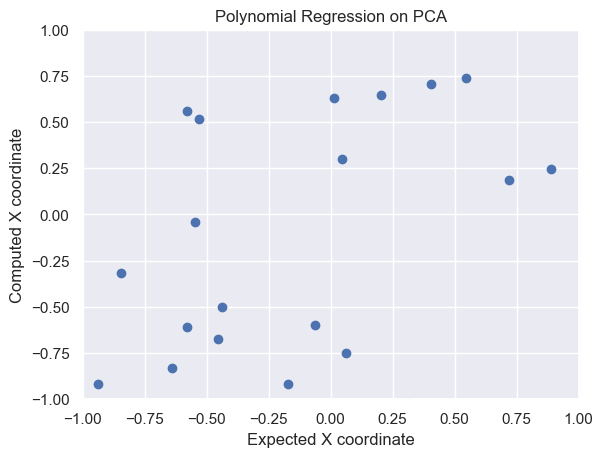

In [15]:
plt.scatter(Y_test, Y_hat["Polynomial on PCA"])
plt.xlabel("Expected X coordinate")
plt.ylabel("Computed X coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Polynomial Regression on PCA")
plt.savefig("../Results/PolynomialRegressionOnPCA"+str(studied_axis)+".jpg", dpi=250)

## LASSO

In [16]:
t = time()
lasso = Lasso(alpha=0.00001, max_iter=25000)
lasso_model = lasso.fit(X, Y)
lasso_t = time()-t
print("Computation time:", lasso_t)

Computation time: 12.071100950241089


In [17]:
t = time()
Y_hat["LASSO"] = lasso_model.predict(X_test)
lasso_mae = np.mean(np.abs(Y_test-Y_hat["LASSO"]))
print("Normalized MAE:", lasso_mae)
lasso_t_1 = time()-t + lasso_t
print("Computation time:", lasso_t_1)
maes["LASSO"] = lasso_mae
times["LASSO"] = lasso_t_1

Normalized MAE: 0.19835915153279826
Computation time: 12.147440910339355


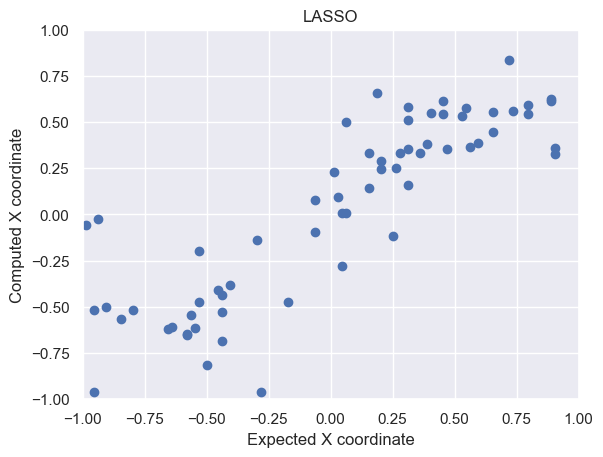

In [18]:
plt.scatter(Y_test, Y_hat["LASSO"] )
plt.xlabel("Expected X coordinate")
plt.ylabel("Computed X coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("LASSO")
plt.savefig("../Results/LASSO"+str(studied_axis)+".jpg", dpi=250)

## Average of all predictions

In [19]:
average = [0 for _ in range(Y_test.shape[0])]
for model in Y_hat:
    for i in range(len(Y_hat[model])):
        average[i] += Y_hat[model][i]
for i in range(len(average)):
    average[i] /= len(Y_hat)

In [20]:
Y_hat["Average"] = average
average_mae = np.mean(np.abs(Y_test-Y_hat["Average"]))
print("Normalized MAE:", average_mae)
maes["Average"] = average_mae

Normalized MAE: 1.481635247577417


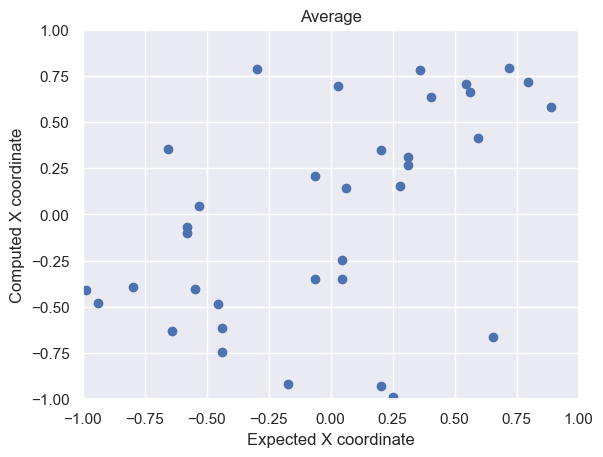

In [21]:
plt.scatter(Y_test, Y_hat["Average"] )
plt.xlabel("Expected X coordinate")
plt.ylabel("Computed X coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Average")
plt.savefig("../Results/Average"+str(studied_axis)+".jpg", dpi=250)

## Results

## Mean Absolute Error for each model

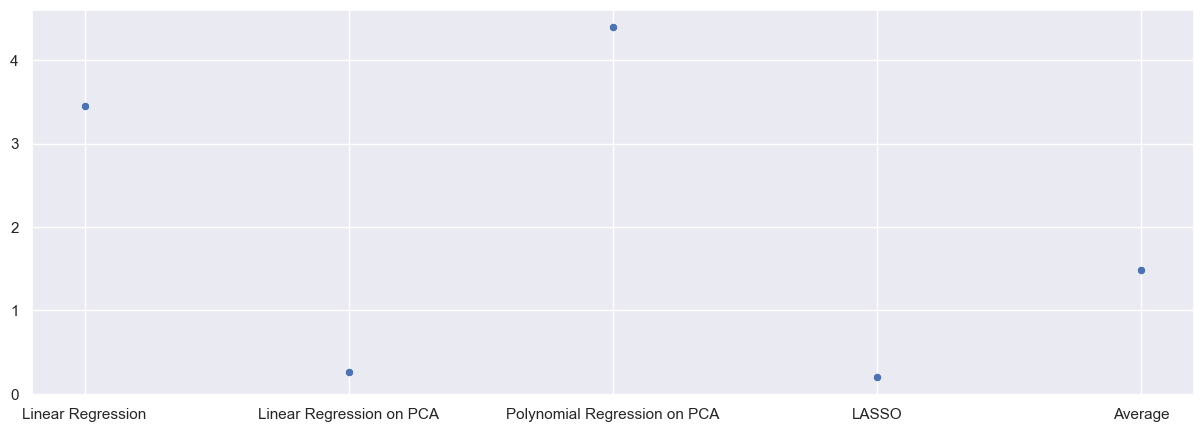

In [22]:
sns.scatterplot(maes).figure.set_size_inches(15, 5)
plt.savefig("../Results/statistical_mae"+str(studied_axis)+".jpg", dpi=250)

## Example
We show an example of prediction from the test set.

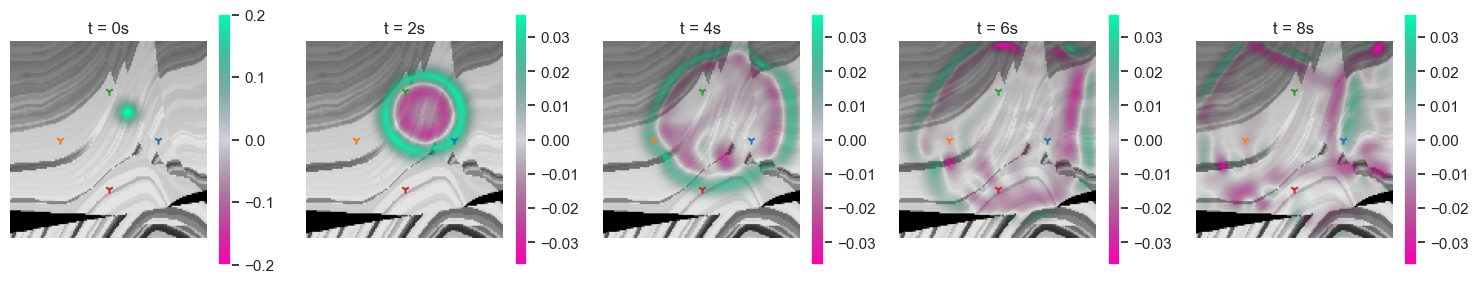

In [23]:
example_sample = 0
test.plot_item(example_sample)

In [24]:
print("Expected epicenter:", test[example_sample][0][0])
print("Predicted epicenter for each model:")
print("\t- Linear:\t\t", Y_hat["Linear"][example_sample]*(test.nx/2))
print("\t- Linear on PCA:\t", Y_hat["Linear on PCA"][example_sample]*(test.nx/2))
print("\t- Polynomial on PCA:\t", Y_hat["Polynomial on PCA"][example_sample]*(test.nx/2))
print("\t- LASSO:\t\t", Y_hat["LASSO"][example_sample]*(test.nx/2))
print("\t- Average:\t\t", Y_hat["Average"][example_sample]*(test.nx/2))

Expected epicenter: -18
Predicted epicenter for each model:
	- Linear:		 -826.6007080078125
	- Linear on PCA:	 52.280033312371536
	- Polynomial on PCA:	 1370.0541744520701
	- LASSO:		 42.0030144400672
	- Average:		 159.4341285491741


## Conclusion
We see that averaging does not lead to better results. LASSO gives the best results in terms of mean absolute error.